# Course Project

## 1. Regression

We will consider both regression and classification problems.


### Data simulation

The simulated data is distributed as follows:

$$
x \sim N(0,R), \quad R \in \mathbb{R}^{p\times p}
$$

$$
y|x \sim N(\omega^Tx, \sigma^2), \quad \sigma^2=1
$$

Where $p$ is the total number of variables (we use $p=100$), $\omega$ are the weights and $R$ is the correlation matrix. 

The variables are separated in group of 5. In each group, $x_j$ has mean zero, variance 1, and correlation $\rho$ with the other variables of the group. $x_j$ is uncorrelated with the variables outside this group. This means that the correlation matrix $R$ is of the form:

$$
R = \begin{pmatrix} 
  \tilde{R}     & 0 & \cdots & 0\\ 
  0 & \tilde{R} & \cdots & 0\\
  \vdots & \cdots & \tilde{R} & 0 \\
  0 & \cdots & \cdots & \tilde{R}
\end{pmatrix}, \quad \tilde{R} = 
\begin{pmatrix}
1 & \rho & \rho & \rho & \rho\\
\rho & 1 & \rho & \rho & \rho \\
\rho & \rho & 1 & \rho & \rho \\
\rho & \rho & \rho & 1 & \rho \\
\rho & \rho & \rho & \rho & 1 
\end{pmatrix}
$$

The weights are of the form:

$$
\begin{pmatrix}
\omega^{1:5}\\
\omega^{6:10}\\
\omega^{11:15}\\
\omega^{16:p}
\end{pmatrix} = 
\begin{pmatrix}
\chi\\
0.5\chi\\
0.25\chi\\
0
\end{pmatrix}
$$

Where $\omega^{1:5}$ denotes the weights of variables $x_1, \cdots, x_5$. That is, there are 15 variables which are informative to the variable $y$, and $p-15$ variables which are uninformative. 

We perform different experiments varying the training size and the correlation coefficient:

$$
n \in \{100,200,400\} \\
\rho \in \{0, 0.5, 0.9\}\\
\chi \in \{0.59, 0.34, 0.28\}
$$

In [1]:
library(MASS)

In [2]:
simulate.regression<-function(n, rho, chi, p=100){
    sigma2<-1
    mu<-rep(0,p)
    
    # Define R-tilde matrix
    Rt<- matrix(rep(rho, 5*5), ncol=5)
    diag(Rt)<-rep(1,5)

    # Define R matrix
    R <- matrix(0, ncol=p, nrow=p)
    for(i in seq(1,p,5)){
        R[i:(i+4), i:(i+4)] <- Rt
    }

    # Define weights
    w<-matrix(0, ncol=1, nrow=p)
    w[1:5,1]<-chi
    w[6:10,1]<-chi*0.5
    w[11:15,1]<-chi*0.25

    # Generate x observations
    x<-mvrnorm(n, mu, R)

    # Generate y observations (given x)
    y<-rnorm(n, t(w)%*%x, sigma2)
    
    return(list('x' = x,'y' = y))
}

In [3]:
# Example simulation experiment
# Define parameters
n <- 100
rho <- 0.5
p <- 100
chi <- 0.34

# Simulate observations
sim<-simulate.regression(n, rho, chi, p)
x<-sim$x
y<-sim$y

### Build model

Now that we have simulated the observations, we will fit a linear regression. We will consider the standard Gaussian model:

$$
y|x, \omega, \sigma^2 \sim N(\omega^Tx, \sigma^2)\\
\omega | \sigma^2, \tau^2 \sim N(0, \tau^2\sigma^2 \mathcal{1})\\
\sigma^2 \sim \text{Inv-Gamma}(\alpha_\sigma, \beta_\sigma)\\
\tau^2 \sim \text{Inv-Gamma}(\alpha_\tau, \beta_\tau)
$$

In this case we will use $\alpha_\sigma = \beta_\sigma = \alpha_\tau = \beta_\tau =0.5$, and we assume that $x$ includes the intercept.

We will fit this model using Stan.

### Formulating the model

In [4]:
modelString.reg = "
   data { 
      int<lower=1> n;   // total number of observations 
      vector[n] y;      // response variable 
      int<lower=1> p;  // number of effects 
      matrix[n,p+1] X;   // model matrix 
      real alphaS;    // alpha sigma^2
      real betaS;    // beta sigma^2
      real alphaT;   // alpha tau^2
      real betaT;    // beta tau^2
      } 
      
   transformed data {
      } 
      
   parameters { 
      vector[p+1] omega;     // linear regression weights
      real<lower=0> sigma;   // standard deviation y
      real<lower=0> tau; // standard deviation omega
      }

   transformed parameters { 
      } 
      
   model { 
      vector[n] mu; 
      mu = X * omega; 
      
      // priors
      omega  ~ normal(0,sigma*tau); 
      sigma ~ inv_gamma(alphaS, betaS);
      tau ~ inv_gamma(alphaT, betaT);

      // likelihood 
      y ~ normal(mu, sigma); 
      } 
      
   generated quantities {
      } 
"

### Generate data for the model


In [6]:
D <- data.frame(y, x)

X.model = model.matrix(y~. , data = D) # This function includes the intercept for the model

data.list <- with(D, list(y = y, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                             alphaS=0.5, betaS=0.5, alphaT=0.5, betaT=0.5))



### Fitting the model

In [5]:
#install.packages("rstan",dependencies=TRUE,repos= "https://cloud.r-project.org")
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



In [10]:
D.Stan <- stan(model_code = modelString.reg, data = data.list , iter = 10000,
             chains = 3, verbose = FALSE, seed=101, warmup=1500)

### Summary of posterior probability

In [11]:
summary(D.Stan)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
omega[1],-0.0256051139,0.0003849817,0.07509955,-0.17685451,-0.073945804,-0.0246355659,0.023996952,0.12205196,38053.49,0.9999277
omega[2],-0.0324976800,0.0005026713,0.07871604,-0.19573714,-0.082255794,-0.0301171489,0.019692933,0.11673004,24522.13,1.0000050
omega[3],0.0167842631,0.0004326939,0.07880128,-0.13899548,-0.034528951,0.0164116825,0.067246188,0.17455497,33166.91,0.9999868
omega[4],0.0108201020,0.0003922583,0.07571242,-0.13972481,-0.038179777,0.0113876794,0.060204128,0.16080133,37255.46,0.9999289
omega[5],0.0275446908,0.0004652888,0.07672102,-0.11900613,-0.023171693,0.0256987001,0.076159237,0.18691498,27188.39,1.0000470
omega[6],0.0035667551,0.0003999198,0.07895963,-0.15470599,-0.047400102,0.0038436763,0.055020449,0.15926798,38982.02,0.9999173
omega[7],-0.0328032875,0.0004245313,0.07602666,-0.18890675,-0.081345341,-0.0309752960,0.018042920,0.11129059,32070.99,0.9999583
omega[8],0.0503211955,0.0005041766,0.07705991,-0.09476163,-0.002044477,0.0474304372,0.099340585,0.20924125,23361.01,0.9999797
omega[9],-0.0193820226,0.0004289514,0.07838596,-0.17920432,-0.070232272,-0.0176470927,0.032238946,0.13159762,33393.38,0.9999463
omega[10],0.0077777841,0.0003810976,0.07628862,-0.14352227,-0.041723469,0.0079428043,0.057833845,0.16027244,40072.55,0.9999168


### Generate a sample from the posterior probability

In [13]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model(model_code=modelString.reg) 

# Generate posterior sample:
stanFit.post<-sampling(object=stanDso,data=data.list,chains=3,iter=10000,warmup=1500,thin=1, seed =101)

In [32]:
# Samples of all the variables

omega.post <- extract(stanFit.post, 'omega')$omega
tau.post <- extract(stanFit.post, 'tau')
tau.post <- unlist(tau.post, use.names=FALSE)
sigma.post <- extract(stanFit.post, 'sigma')
sigma.post <- unlist(sigma.post, use.names=FALSE)

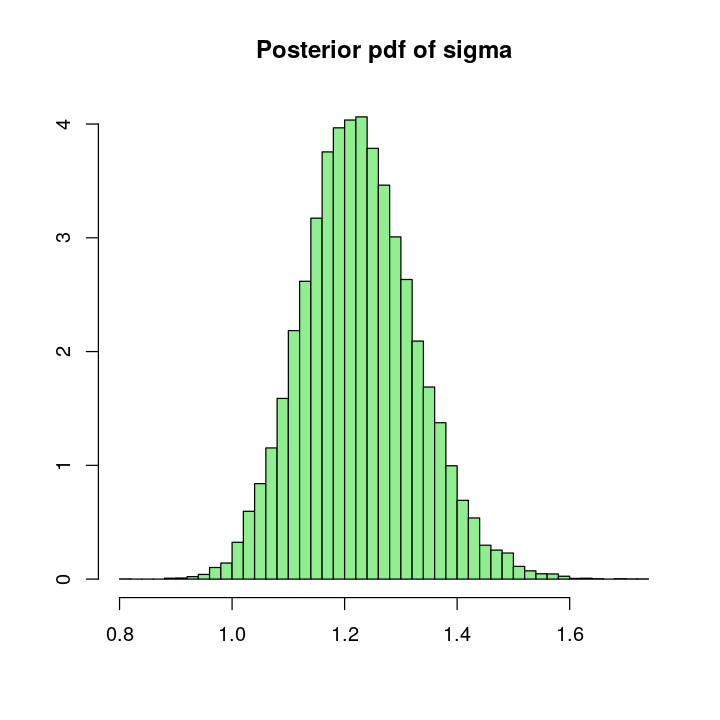

In [36]:
options(repr.plot.width=6,repr.plot.height=6)
hist(sigma.post,freq=FALSE,col="LightGreen",breaks=60,xlab="",ylab="",main="Posterior pdf of sigma")


### Obtain probability distribution of new observations

In [58]:
# Given a new observation x.new
sim.new<-simulate.regression(1, rho, chi, p)
x.new<-as.matrix(sim.new$x)
x.new.ext<-rbind(1,x.new)


# Generate the probability distribution y|x,omega,sigma,tau
# Draw samples of y from the likelihood, using the posterior parameters

get_y_distr<-function(x.new, omega.post, sigma.post){
    x.new.ext<-rbind(1,x.new)
    mu<-omega.post%*%x.new.ext
    sd<-sigma.post
    n.samp<-length(sigma.post)
    y.samp<-rnorm(n.samp, mu, sd)
    return(y.samp)
}

y.samp<-get_y_distr(x.new, omega.post, sigma.post)

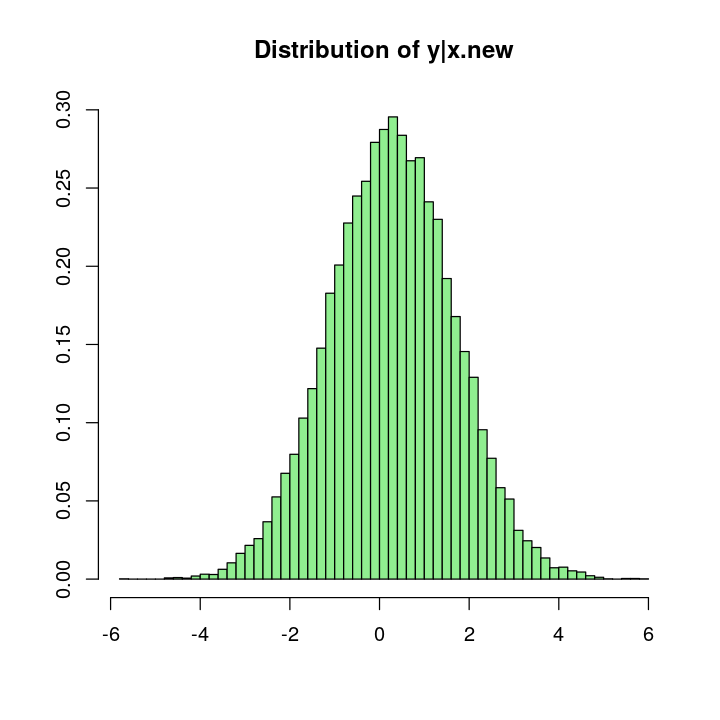

In [57]:
options(repr.plot.width=6,repr.plot.height=6)
hist(y.samp,freq=FALSE,col="LightGreen",breaks=60,xlab="",ylab="",main="Distribution of y|x.new")


## Putting it all together

The following function calculates a Bayesian Linear Regression, given an initial dataset and prior parameters. It returns the posterior quantities. These quantities can be used to generate the labels probability distribution $\tilde{y}|x,\omega,\sigma,\tau$. 


In [5]:
fit.linear.regression<-function(x,y,alphaS, betaS, alphaT, betaT, modelString){
    # Load Stan package
    options(mc.cores = parallel::detectCores())
    require(rstan)
    rstan_options(auto_write = TRUE)
    Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')
    
    
    # Create data for Stan
    D <- data.frame(y, x)
    X.model = model.matrix(y~. , data = D) # This function includes the intercept for the model
    data.list <- with(D, list(y = y, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                                 alphaS=alphaS, betaS=betaS, alphaT=alphaT, betaT=betaT))

    # Translate model to C++ and compile to DSO:
    stanDso <- stan_model(model_code=modelString) 

    # Generate posterior sample:
    stanFit.post<-sampling(object=stanDso,data=data.list,chains=3,iter=10000,warmup=1500,thin=1, seed =101)

    # Samples of all the variables
    omega.post <- extract(stanFit.post, 'omega')$omega
    tau.post <- extract(stanFit.post, 'tau')
    tau.post <- unlist(tau.post, use.names=FALSE)
    sigma.post <- extract(stanFit.post, 'sigma')
    sigma.post <- unlist(sigma.post, use.names=FALSE)
    
    return(list(omega.post = omega.post, tau.post = tau.post, sigma.post = sigma.post))    
}


get.y.distr.reg<-function(x.new, omega.post, sigma.post){
    x.new.ext<-rbind(1,x.new)
    mu<-omega.post%*%x.new.ext
    sd<-sigma.post
    n.samp<-length(sigma.post)
    y.samp<-rnorm(n.samp, mu, sd)
    return(y.samp)
}


get.y.probs.reg<-function(x.new, omega.post, sigma.post, q){
    # q is the vector of quantiles to obtain the probabilities
    y.samp<-get.y.distr.reg(x.new, omega.post, sigma.post)
    dens<-density(y.samp)
    probs <- approx(dens$x,dens$y,xout=q)$y
    return(probs)
}

In [6]:
# Example

# Fit linear model and generate posterior quantities
linear.fit<-fit.linear.regression(x,y,0.5,0.5,0.5,0.5, modelString.reg)
omega.post<-linear.fit$omega.post
tau.post<-linear.fit$tau.post
sigma.post<-linear.fit$sigma.post

# New observation
sim.new<-simulate.regression(1, rho, chi, p)
x.new<-as.matrix(sim.new$x)

# Get probability density of different values of y
probs<-get.y.probs.reg(x.new, omega.post, sigma.post, seq(-4,4,0.1))

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



## 2. Classification model

### Data simulation

The second type of models we are going to consider are Classification models. 
In this case, we will simulate binary data according to a probit model. The data simulation process is the following:

$$
x \sim N(0,R), \quad R \in \mathbb{R}^{p\times p}
$$

$$
y|x \sim Ber(\Phi(\omega^Tx))
$$

Where $R$ is the same correlation matrix as the one used in the regression problem, and $\Phi$ is the cumulative distribution function of a Gaussian distribution. The weights $\omega$ and the parameters $n, \rho, \chi, p$ are the same as the ones used in the regression problem.

In [4]:
library(MASS)

simulate.classification<-function(n, rho, chi, p=100){
    mu<-rep(0,p)
    
    # Define R-tilde matrix
    Rt<- matrix(rep(rho, 5*5), ncol=5)
    diag(Rt)<-rep(1,5)

    # Define R matrix
    R <- matrix(0, ncol=p, nrow=p)
    for(i in seq(1,p,5)){
        R[i:(i+4), i:(i+4)] <- Rt
    }

    # Define weights
    w<-matrix(0, ncol=1, nrow=p)
    w[1:5,1]<-chi
    w[6:10,1]<-chi*0.5
    w[11:15,1]<-chi*0.25

    # Generate x observations
    x<-mvrnorm(n, mu, R)

    # Generate y observations (given x)
    y<-rbinom(n,1, pnorm(t(w)%*%x))
    
    return(list('x' = x,'y' = y))
}

In [5]:
# Example simulation experiment
# Define parameters
n <- 100
rho <- 0.5
p <- 100
chi <- 0.34

# Simulate observations
sim<-simulate.classification(n, rho, chi, p)
x<-sim$x
y<-sim$y

### Build model

Now that we have simulated the observations, we will fit a linear regression. We will consider the standard Gaussian model:

$$
y|x, \omega \sim Ber(\Phi(\omega^Tx))\\
\omega |  \tau^2 \sim N(0, \tau^2 \mathcal{1})\\
\tau^2 \sim \text{Inv-Gamma}(\alpha_\tau, \beta_\tau)
$$

In this case we will use $ \alpha_\tau = \beta_\tau =0.5$, and we assume that $x$ includes the intercept.

We will fit this model using Stan.

### Formulating the model

In [6]:
modelString.class = "
   data { 
      int<lower=1> n;   // total number of observations 
      int<lower=0,upper=1> y[n];      // response variable 
      int<lower=1> p;  // number of effects 
      matrix[n,p+1] X;   // model matrix 
      real alphaT;   // alpha tau^2
      real betaT;    // beta tau^2
      } 
      
   transformed data {
      } 
      
   parameters { 
      vector[p+1] omega;     // linear regression weights
      real<lower=0> tau; // standard deviation omega
      }

   transformed parameters { 
      } 
      
   model { 
      vector[n] mu; 
      mu = X * omega; 
      
      // priors
      omega  ~ normal(0,tau); 
      tau ~ inv_gamma(alphaT, betaT);

      // likelihood 
      //for (i in 1:n)
      //  y[i] ~ bernoulli(Phi_approx(mu[i])); 
      y ~ bernoulli_logit(mu);

      } 
      
   generated quantities {
      } 
"

In [18]:
fit.probit<-function(x,y, alphaT, betaT, modelString){
    # Load Stan package
    options(mc.cores = parallel::detectCores())
    require(rstan)
    rstan_options(auto_write = TRUE)
    Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')
    
    
    # Create data for Stan
    D <- data.frame(y, x)
    X.model = model.matrix(y~. , data = D) # This function includes the intercept for the model
    data.list <- with(D, list(y = y, X = X.model, p= ncol(X.model)- 1, n=nrow(D), 
                                alphaT=alphaT, betaT=betaT))

    # Translate model to C++ and compile to DSO:
    stanDso <- stan_model(model_code=modelString) 

    # Generate posterior sample:
    stanFit.post<-sampling(object=stanDso,data=data.list,chains=3,iter=10000,warmup=1500,thin=1, seed =101)

    # Samples of all the variables
    omega.post <- extract(stanFit.post, 'omega')$omega
    tau.post <- extract(stanFit.post, 'tau')
    tau.post <- unlist(tau.post, use.names=FALSE)

    return(list(omega.post = omega.post, tau.post = tau.post))    
}


get.y.distr.class<-function(x.new, omega.post){
    x.new.ext<-rbind(1,x.new)
    p<-pnorm(omega.post%*%x.new.ext)
    n.samp<-length(tau.post)
    y.samp<-rbinom(n.samp, 1, p)
    return(y.samp)
}


get.y.probs.class<-function(x.new, omega.post){
    y.samp<-get.y.distr.class(x.new, omega.post)
    p<-sum(y.samp)/length(y.samp)
    return(p)
}


In [19]:
# Example

# Fit linear model and generate posterior quantities
linear.fit<-fit.probit(x,y,0.5, 0.5, modelString.class)
omega.post<-linear.fit$omega.post
tau.post<-linear.fit$tau.post

# New observation
sim.new<-simulate.classification(1, rho, chi, p)
x.new<-as.matrix(sim.new$x)

# Get probability density of different values of y
prob<-get.y.probs.class(x.new, omega.post)

prob

Warning message:
“There were 5 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


[1] 0.3056863